In [28]:
# source code

import math
import numpy as np
from scipy import optimize
import scipy.io as io
def fourvar_jac(S,parameter,mu,coh,See,Sei,Sie,Sii):
    # jacobian

    tau_nmda = .100
    tau_gaba = .005
    tau_ampa = .002

    taus = np.zeros([4])
    taus[0] = tau_nmda
    taus[1] = tau_nmda
    taus[2] = tau_gaba
    taus[3] = tau_gaba

    aE = 310
    bE = 125
    dE = 0.16 

    aI = 615 
    bI = 177 
    dI = 0.087 

    Jampa_ext = 5.2e-4 

    gamma = 0.641 

    Ns = 2 
    w_e = 1 
    w_i = 1 

    what_ee = Ns*w_e/(Ns + See*(2 - Ns)) 
    what_ei = Ns*w_e/(Ns + Sei*(2 - Ns)) 
    what_ie = Ns*w_i/(Ns + Sie*(2 - Ns)) 
    what_ii = Ns*w_i/(Ns + Sii*(2 - Ns)) 

    wpee = what_ee + See*what_ee 
    wmee = what_ee - See*what_ee 
    w0ee = w_e  

    wpei = what_ei + Sei*what_ei 
    wmei = what_ei - Sei*what_ei 
    w0ei = w_e  

    wpie = what_ie + Sie*what_ie 
    wmie = what_ie - Sie*what_ie 
    w0ie = w_i 

    wpii = what_ii + Sii*what_ii 
    wmii = what_ii - Sii*what_ii 
    w0ii = w_i 

    A = np.zeros([4,4]) 

    A[0,:] = [wpee*parameter['JnmdaE'][0,0],wmee*parameter['JnmdaE'][0,0],wpie*parameter['JgabaE'][0,0],wmie*parameter['JgabaE'][0,0]]  #inputs to E1
    A[1,:] = [wmee*parameter['JnmdaE'][0,0],wpee*parameter['JnmdaE'][0,0],wmie*parameter['JgabaE'][0,0],wpie*parameter['JgabaE'][0,0]]  #inputs to E2
    A[2,:] = [wpei*parameter['JnmdaI'][0,0],wmei*parameter['JnmdaI'][0,0],wpii*parameter['JgabaI'][0,0],wmii*parameter['JgabaI'][0,0]]  #inputs to I1
    A[3,:] = [wmei*parameter['JnmdaI'][0,0],wpei*parameter['JnmdaI'][0,0],wmii*parameter['JgabaI'][0,0],wpii*parameter['JgabaI'][0,0]]  #inputs to I2

    I0 = np.zeros([4])
    I0[0] = parameter['I0E']
    I0[1] = parameter['I0E']
    I0[2] = parameter['I0I']
    I0[3] = parameter['I0I']
    
    I_stim = np.zeros([4])
    H      = np.zeros([4])
    
    dHds   = np.zeros([4,4])
    dsds   = np.zeros([4,4])
    
    
    I_stim[0] = Jampa_ext * mu * (1+coh/100) 
    I_stim[1] = Jampa_ext * mu * (1-coh/100)

    dxds = A

    x = np.matmul(A,S) + I0 + I_stim
    H[0:2] = (aE*x[0:2] - bE)/(1 - np.exp(-dE*(aE*x[0:2] - bE))) 
    H[2:4] = (aI*x[2:4] - bI)/(1 - np.exp(-dI*(aI*x[2:4] - bI)))
    #S is an input

    for i in range(4):
        dHds[0,i] = (aE*dxds[0,i]*(1 - np.exp(-dE*(aE*x[0]-bE))) - aE*dE*np.exp(-dE*(aE*x[0]-bE))*dxds[0,i]*(aE*x[0]-bE))/ ((1 - np.exp(-dE*(aE*x[0] - bE))))**2
        dHds[1,i] = (aE*dxds[1,i]*(1 - np.exp(-dE*(aE*x[1]-bE))) - aE*dE*np.exp(-dE*(aE*x[1]-bE))*dxds[1,i]*(aE*x[1]-bE))/ ((1 - np.exp(-dE*(aE*x[1] - bE))))**2
        dHds[2,i] = (aI*dxds[2,i]*(1 - np.exp(-dI*(aI*x[2]-bI))) - aI*dI*np.exp(-dI*(aI*x[2]-bI))*dxds[2,i]*(aI*x[2]-bI))/ ((1 - np.exp(-dI*(aI*x[2] - bI))))**2
        dHds[3,i] = (aI*dxds[3,i]*(1 - np.exp(-dI*(aI*x[3]-bI))) - aI*dI*np.exp(-dI*(aI*x[3]-bI))*dxds[3,i]*(aI*x[3]-bI))/ ((1 - np.exp(-dI*(aI*x[3] - bI))))**2

#     dsds[0,0] = -1/taus[0] + gamma*dHds[0,0] - (H[0] + S[0]*dHds[0,0])
#     dsds[1,1] = -1/taus[1] + gamma*dHds[1,1] - (H[1] + S[1]*dHds[1,1])
#     dsds[2,2] = -1/taus[2] + gamma*dHds[2,2] - (H[2] + S[2]*dHds[2,2])
#     dsds[3,3] = -1/taus[3] + gamma*dHds[3,3] - (H[3] + S[3]*dHds[3,3])

    dsds[0,0] = (-1/taus[0]) + gamma*(-H[0] + dHds[0,0]*(1-S[0]))
    dsds[1,1] = (-1/taus[1]) + gamma*(-H[1] + dHds[1,1]*(1-S[1]))
    dsds[2,2] = (-1/taus[2]) + dHds[2,2]
    dsds[3,3] = (-1/taus[3]) + dHds[3,3]

    for i in [0,1]:
        for j in range(4):
            if i != j:
#                 dsds[i,j] = gamma*dHds[i,j] - S[i]*dHds[i,j]
#                 dsds[i,j] = -gamma*(1-S[i])*dHds[i,j]
                dsds[i,j] = gamma*(1-S[i])*dHds[i,j]
    for i in [2,3]:
        for j in range(4):
            if i != j:
#                 dsds[i,j] = gamma*dHds[i,j] - S[i]*dHds[i,j]
#                 dsds[i,j] = -gamma*(1-S[i])*dHds[i,j]
                dsds[i,j] = dHds[i,j]
    return dsds

def dsdt(S,parameter,mu,coh,See,Sei,Sie,Sii):
    tau_nmda = .100
    tau_gaba = .005
    tau_ampa = .002

    taus = np.zeros([4])
    taus[0] = tau_nmda
    taus[1] = tau_nmda
    taus[2] = tau_gaba
    taus[3] = tau_gaba

    aE = 310
    bE = 125
    dE = 0.16 

    aI = 615 
    bI = 177 
    dI = 0.087 

    Jampa_ext = 5.2e-4 

    gamma = 0.641 

    Ns = 2 
    w_e = 1 
    w_i = 1 

    what_ee = Ns*w_e/(Ns + See*(2 - Ns)) 
    what_ei = Ns*w_e/(Ns + Sei*(2 - Ns)) 
    what_ie = Ns*w_i/(Ns + Sie*(2 - Ns)) 
    what_ii = Ns*w_i/(Ns + Sii*(2 - Ns)) 

    wpee = what_ee + See*what_ee 
    wmee = what_ee - See*what_ee 
    w0ee = w_e  

    wpei = what_ei + Sei*what_ei 
    wmei = what_ei - Sei*what_ei 
    w0ei = w_e  

    wpie = what_ie + Sie*what_ie 
    wmie = what_ie - Sie*what_ie 
    w0ie = w_i 

    wpii = what_ii + Sii*what_ii 
    wmii = what_ii - Sii*what_ii 
    w0ii = w_i 

    A = np.zeros([4,4]) 

    A[0,:] = [wpee*parameter['JnmdaE'][0,0],wmee*parameter['JnmdaE'][0,0],wpie*parameter['JgabaE'][0,0],wmie*parameter['JgabaE'][0,0]]  #inputs to E1
    A[1,:] = [wmee*parameter['JnmdaE'][0,0],wpee*parameter['JnmdaE'][0,0],wmie*parameter['JgabaE'][0,0],wpie*parameter['JgabaE'][0,0]]  #inputs to E2
    A[2,:] = [wpei*parameter['JnmdaI'][0,0],wmei*parameter['JnmdaI'][0,0],wpii*parameter['JgabaI'][0,0],wmii*parameter['JgabaI'][0,0]]  #inputs to I1
    A[3,:] = [wmei*parameter['JnmdaI'][0,0],wpei*parameter['JnmdaI'][0,0],wmii*parameter['JgabaI'][0,0],wpii*parameter['JgabaI'][0,0]]  #inputs to I2

    I0 = np.zeros([4])
    I0[0] = parameter['I0E']
    I0[1] = parameter['I0E']
    I0[2] = parameter['I0I']
    I0[3] = parameter['I0I']

#     S      = np.zeros([4])
    Inoise = np.zeros([4])
    I_stim = np.zeros([4])
    x      = np.zeros([4])
    H      = np.zeros([4])
    dS     = np.zeros([4])

    # stim
    I_stim[0] = Jampa_ext * mu * (1+coh/100) 
    I_stim[1] = Jampa_ext * mu * (1-coh/100)
    # input
    x[:] = np.matmul(A,S) + I0 + I_stim
    # freq
    H[0:2]  = (aE*x[0:2] - bE)/(1 - np.exp(-dE*(aE*x[0:2] - bE))) 
    H[2:4]  = (aI*x[2:4] - bI)/(1 - np.exp(-dI*(aI*x[2:4] - bI))) 
    # s
    dS[0:2] = -1*(taus[0:2]**-1)*S[0:2] + (1-S[0:2])*gamma*H[0:2]
    dS[2:4] = -1*(taus[2:4]**-1)*S[2:4] + H[2:4]

    return dS

def eval_single_trial(run,time):
    
    N = 20
    x0 = np.convolve(run['data'][0,:],np.ones(N)/N,mode='same')
    x1 = np.convolve(run['data'][1,:],np.ones(N)/N,mode='same')
    x2 = np.convolve(run['data'][2,:],np.ones(N)/N,mode='same')
    x3 = np.convolve(run['data'][3,:],np.ones(N)/N,mode='same')
    
    runC = {'data':np.concatenate([np.expand_dims(x0,0),np.expand_dims(x1,0),
                                   np.expand_dims(x2,0),np.expand_dims(x3,0)],axis=0)}
    
    st_on  = int(time['on']/time['dt'])
    st_off = int(time['off']/time['dt'])
    
    adiff = np.abs(runC['data'][0,:]-runC['data'][1,:])
    # screen for early separation
    if (adiff[:st_on] < 5).all() & (adiff[st_on:st_off] > 15).any() & (runC['data'][:,st_off] > 15).any():
        #valid trial
        # get choice and reaction time
        focus_diff = np.abs(runC['data'][0,st_on:]-runC['data'][1,st_on:])
        focus      = runC['data'][:,st_on:]
        above_thresh = np.where(focus_diff>15)[0]
        if np.diff(above_thresh).any() > 1:
            choice_dex = above_thresh[np.where(np.diff(above_thresh)>1)[0][-1]]
        else:
            choice_dex = above_thresh[0]
        
        choice = np.argmax(focus[0:2,choice_dex])
        rt     = choice_dex*time['dt']
        outcome = True
    else:
        #invalid trial
        choice = math.nan
        rt     = math.nan
        outcome = False
    trial_data = {'choice':choice,
                  'rt':rt,
                  'outcome':outcome,
                  'runC':runC,
                  }
    return trial_data

def selective_inh_foureqn_prod(parameter,coh,See,Sei,Sie,Sii,sig_noise,time):
    tau_nmda = .100
    tau_gaba = .005
    tau_ampa = .002

    taus = np.zeros([4])
    taus[0] = tau_nmda
    taus[1] = tau_nmda
    taus[2] = tau_gaba
    taus[3] = tau_gaba

    aE = 310
    bE = 125
    dE = 0.16 

    aI = 615 
    bI = 177 
    dI = 0.087 

    #     parameter['JnmdaE'] = 0.1397 
    #     parameter['JnmdaI'] = 0.1109 
    #     parameter['JgabaE'] = -0.1608 
    #     parameter['JgabaI'] = -0.0404 

    #     parameter['I0E'] = 0.5855 
    #     parameter['I0I'] = 0.4555 

    Jampa_ext = 5.2e-4 

    gamma = 0.641 

    mu = 40 
#     coh = 50.0 

    st_on  = time['on']
    st_off = time['off']

#     sig_noise = 0.02 
    
    dt = time['dt']
    # dt = 0.002
    T = int(time['end']/dt +1) 
     

    Ns = 2 
    w_e = 1 
    w_i = 1 

#     See = 0.32 
#     Sei = 0.25 
#     Sie = 0 
#     Sii = 0 

    what_ee = Ns*w_e/(Ns + See*(2 - Ns)) 
    what_ei = Ns*w_e/(Ns + Sei*(2 - Ns)) 
    what_ie = Ns*w_i/(Ns + Sie*(2 - Ns)) 
    what_ii = Ns*w_i/(Ns + Sii*(2 - Ns)) 

    wpee = what_ee + See*what_ee 
    wmee = what_ee - See*what_ee 
    w0ee = w_e  

    wpei = what_ei + Sei*what_ei 
    wmei = what_ei - Sei*what_ei 
    w0ei = w_e  

    wpie = what_ie + Sie*what_ie 
    wmie = what_ie - Sie*what_ie 
    w0ie = w_i 

    wpii = what_ii + Sii*what_ii 
    wmii = what_ii - Sii*what_ii 
    w0ii = w_i 

    A = np.zeros([4,4]) 

    A[0,:] = [wpee*parameter['JnmdaE'][0,0],wmee*parameter['JnmdaE'][0,0],wpie*parameter['JgabaE'][0,0],wmie*parameter['JgabaE'][0,0]]  #inputs to E1
    A[1,:] = [wmee*parameter['JnmdaE'][0,0],wpee*parameter['JnmdaE'][0,0],wmie*parameter['JgabaE'][0,0],wpie*parameter['JgabaE'][0,0]]  #inputs to E2
    A[2,:] = [wpei*parameter['JnmdaI'][0,0],wmei*parameter['JnmdaI'][0,0],wpii*parameter['JgabaI'][0,0],wmii*parameter['JgabaI'][0,0]]  #inputs to I1
    A[3,:] = [wmei*parameter['JnmdaI'][0,0],wpei*parameter['JnmdaI'][0,0],wmii*parameter['JgabaI'][0,0],wpii*parameter['JgabaI'][0,0]]  #inputs to I2

    print(A)
    I0 = np.zeros([4])
    I0[0] = parameter['I0E']
    I0[1] = parameter['I0E']
    I0[2] = parameter['I0I']
    I0[3] = parameter['I0I']

    S      = np.zeros([4,T])
    dS     = np.zeros([4,T])
    Inoise = np.zeros([4,T])
    I_stim = np.zeros([4,T])
    x      = np.zeros([4,T])
    H      = np.zeros([4,T])

    S[0:2,0]      = (np.random.rand(2)*0.05 + 0.0)
    S[2:4,0]      = (np.random.rand(2)*0.05 + 0.275)
    Inoise[:,0] = np.random.randn(4)*math.sqrt(tau_ampa)*sig_noise 

    for i in range(1,T):
        # noise
        dn = (dt/tau_ampa)*(-Inoise[:,i-1]) + np.random.randn(4)*math.sqrt(tau_ampa)*sig_noise 
    #     dn = (dt/Tampa)*(-I_eta1(t)) + sqrt(dt/Tampa)*noise_amp*corr_noise(1)
        Inoise[:,i] = Inoise[:,i-1] + dn 
        # stim
        I_stim[0,i] = Jampa_ext * mu * (1+coh/100)*((i>st_on/dt)&(i<=st_off/dt)) 
        I_stim[1,i] = Jampa_ext * mu * (1-coh/100)*((i>st_on/dt)&(i<=st_off/dt)) 
        # input
#         if i < 15:
#             x[:,i] = np.matmul(A,S[:,i-1]) + I_stim[:,i] + Inoise[:,i] 
#         else:
        x[:,i] = np.matmul(A,S[:,i-1]) + I0 + I_stim[:,i] + Inoise[:,i] 
        # freq
        H[0:2,i] = (aE*x[0:2,i] - bE)/(1 - np.exp(-dE*(aE*x[0:2,i] - bE))) 
        H[2:4,i] = (aI*x[2:4,i] - bI)/(1 - np.exp(-dI*(aI*x[2:4,i] - bI))) 
        # s
        dS[0:2,i] = -1*(taus[0:2]**-1)*S[0:2,i-1] + (1-S[0:2,i-1])*gamma*H[0:2,i]
        dS[2:4,i] = -1*(taus[2:4]**-1)*S[2:4,i-1] + H[2:4,i]
        S[:,i]    = S[:,i-1] + dS[:,i]*dt 
    #     if for_abc:    
    #         return {'data':H[0:1,:]}
    #     else:
    return {'data':H, 'S':S}

def gen_psychometrics(runs,see,sei,sie,sii,s_lo,s_hi,abc_good_prams,time):
    coh = np.arange(s_lo,s_hi,2)
    # sie = np.array([-0.01,0,0.01])
    
    # see = 0.32
    # sei = 0.25
    # sii = 0.0
    
    st_noise = 0.2 #0.2 works well for sie=0
    
    # runs = 1000
    
    psycho = np.nan*np.ones([len(coh),runs])
    chrono = np.nan*np.ones([len(coh),runs])
    ntrial = np.nan*np.ones([len(coh),runs])
    
    for i in range(len(coh)):
        for k in range(runs):
            run = selective_inh_foureqn_prod(abc_good_prams,coh[i],see,sei,sie,sii,st_noise,time)
            trial_data = eval_single_trial(run,time)
            if trial_data['outcome']:
                psycho[i,k] = trial_data['choice']
                chrono[i,k] = trial_data['rt']
                ntrial[i,k] = 1
            # print('parameter: coh= '+str(coh[i])+' sie= '+str(sie[j])+' completed')
    return {'psycho':psycho, 'chrono':chrono, 'ntrial':ntrial, 'coh':coh}

def get_fixed_points(see,sei,sie,sii,mu,coh,abc_good_prams):
    s = np.arange(0,1,0.1)
    
    # mu  = 40
    # coh = 0
    # see = 0.32
    # sei = 0.25
    # # sie = [-0.01,0,0.01]
    # sie = np.arange(-0.1,0.1,0.01)
    # sii = 0.0
    pts = []
    good = []
    ddS  = []
    tol  = 1e-6
    stol = 1e-6
    for i in range(len(s)):
        for j in range(len(s)):
            # for k in range(len(s)):
            #     for l in range(len(s)):
            # sol = optimize.root(dsdt, np.array([s[i],0.5,0.5,s[j]]),method='lm',options={'xtol':1e-6},args=(abc_good_prams,mu,coh,see,sei,sie,sii),jac=fourvar_jac)
    #         sol = optimize.root(dsdt, np.array([s[i],0.5,0.5,s[j]]),args=(abc_good_prams,mu,coh,see,sei,sie,sii))
            sol = optimize.fsolve(dsdt, np.array([s[i],0.5,0.5,s[j]]),args=(abc_good_prams,mu,coh,see,sei,sie,sii),fprime=fourvar_jac)
            # sol = sol.x
            # print(sol)
            sol_ds = np.sqrt(np.sum(dsdt(sol,abc_good_prams,mu,coh,see,sei,sie,sii)**2))
            if sol_ds < tol:
                if (len(pts)>0):
                    if (np.any(np.sqrt(np.sum((pts-sol)**2,axis=1))<stol)):
                        for q,w in enumerate(np.where(np.sqrt(np.sum((pts-sol)**2,axis=1))<stol)[0]):
                            if sol_ds < ddS[w]:
                                pts[w] = sol 
                                ddS[w] = sol_ds
                    else:
                        pts.append(sol)
                        ddS.append(sol_ds)
                else:
                    pts.append(sol)
                    ddS.append(sol_ds)
            # sol = optimize.root(dsdt, np.array([0.5,s[i],s[j],0.5]),method='lm',options={'xtol':1e-6},args=(abc_good_prams,mu,coh,see,sei,sie,sii),jac=fourvar_jac)    
            sol = optimize.fsolve(dsdt, np.array([0.5,s[i],s[j],0.5]),args=(abc_good_prams,mu,coh,see,sei,sie,sii),fprime=fourvar_jac)
            # sol = sol.x
            sol_ds = np.sqrt(np.sum(dsdt(sol,abc_good_prams,mu,coh,see,sei,sie,sii)**2))
            if sol_ds < tol:
                if (len(pts)>0):
                    if (np.any(np.sqrt(np.sum((pts-sol)**2,axis=1))<stol)):
                        for q,w in enumerate(np.where(np.sqrt(np.sum((pts-sol)**2,axis=1))<stol)[0]):
                            if sol_ds < ddS[w]:
                                pts[w] = sol 
                                ddS[w] = sol_ds
                    else:
                        pts.append(sol)
                        ddS.append(sol_ds)
                else:
                    pts.append(sol)
                    ddS.append(sol_ds)
            # pts.append(sol)
            # ddS.append(np.sqrt(np.sum(dsdt(sol,abc_good_prams,mu,coh,see,sei,sie,sii)**2)))
            # good.append(sol.success)

            # sol = optimize.root(dsdt, np.array([0.5,s[i],s[j],0.5]),method='lm',options={'xtol':1e-6},args=(abc_good_prams,mu,coh,see,sei,sie,sii),jac=fourvar_jac)
            # sol = optimize.fsolve(dsdt, np.array([0.5,s[i],s[j],0.5]),args=(abc_good_prams,mu,coh,see,sei,sie,sii),fprime=fourvar_jac)
            # pts.append(sol)
            # ddS.append(np.sqrt(np.sum(dsdt(sol,abc_good_prams,mu,coh,see,sei,sie,sii)**2)))
            # good.append(sol.success)
    pts   = np.array(pts)
    # keep  = (np.array(good))&(np.array(ddS)<0.1)
    # keep  = (np.array(ddS)<1e-6)
    # pts   = pts[keep]
    # ddS   = np.array(ddS)[keep]
    
    # pts   = np.round(pts,4)
    # fps   = np.unique(pts,axis=0)
    fps   = pts[np.isfinite(pts).all(axis=1),:]
    fps   = fps[np.argsort(fps[:,0]),:]
    stab  = np.zeros([fps.shape[0]])
    # dS    = np.zeros([fps.shape[0]],dtype='object')
    evals = [] 
    for i in range(fps.shape[0]):
        jac = fourvar_jac(fps[i],abc_good_prams,mu,coh,see,sei,sie,sii)
        # dS[i] = dsdt(fps[i],abc_good_prams,mu,coh,see,sei,sie,sii)
        if np.isfinite(jac).all():
            egs = np.linalg.eig(jac)
            evals.append(egs[0])
            if (egs[0]<0).all():
                stab[i] = 1
        else:
            stab[i] = np.nan
            evals.append(np.array([np.nan]))
            
            
    return {'points':fps,'stable':stab,'eiganvalues':evals, 'dS':ddS}        
                
def fourD_fixedpoint_scan(see_arr,sei_arr,sie_arr,sii_arr,abc_good_prams):
    
    mu = 40
    coh = 0
    
    one_pts = see_arr.shape[0]
    two_pts = sei_arr.shape[0]
    thr_pts = sie_arr.shape[0]
    fou_pts = sii_arr.shape[0]
    
    ustim = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='bool')
    stim  = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='bool')
    
    s_pts  = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='object')
    s_stab = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='object')
    s_dS   = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='object')
    
    u_pts  = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='object')
    u_stab = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='object')
    u_dS   = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='object')
    
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # for i in tqdm(range(one_pts), desc=" EE loop", position=0):
        #     for j in tqdm(range(two_pts), desc=" EI loop", position=1,leave=False):
        #         for k in tqdm(range(thr_pts), desc=" IE loop", position=2,leave=False):
        #             for l in tqdm(range(fou_pts), desc=" II loop", position=3,leave=False):
        for i in range(one_pts):
            for j in range(two_pts):
                for k in range(thr_pts):
                    for l in range(fou_pts):
                        stim_pts  = get_fixed_points(see_arr[i],sei_arr[j],sie_arr[k],sii_arr[l],mu,coh,abc_good_prams)
                        ustim_pts = get_fixed_points(see_arr[i],sei_arr[j],sie_arr[k],sii_arr[l],0,coh,abc_good_prams)
                        ustim[i,j,k,l] = np.all(ustim_pts['stable'] == np.array([1,0,1,0,1]))
                        stim[i,j,k,l]  = np.all(stim_pts['stable'] == np.array([1,0,1]))
                        
                        s_pts[i,j,k,l]  = stim_pts['points']
                        s_stab[i,j,k,l] = stim_pts['stable']
                        s_dS[i,j,k,l]   = stim_pts['dS']
                        
                        u_pts[i,j,k,l]  = ustim_pts['points']
                        u_stab[i,j,k,l] = ustim_pts['stable']
                        u_dS[i,j,k,l]   = ustim_pts['dS']
                        
                        print(np.array([see_arr[i],sei_arr[j],sie_arr[k],sii_arr[l]]))
    gdd_points = {'is_good': ustim&stim,
                  's_pts': s_pts,
                  's_stab': s_stab,
                  's_dS': s_dS,
                  'u_pts': u_pts,
                  'u_stab': u_stab,
                  'u_dS': u_dS,
                  }
    
    return gdd_points
    

time = {'on':2,'off':4,'end':5,'dt': 0.002}
abc_good_prams = io.loadmat('./abc_good_params20220913175356 (1).mat')

[[ 0.55896398  0.28795114 -0.46992407 -0.46992407]
 [ 0.28795114  0.55896398 -0.46992407 -0.46992407]
 [ 0.7178929   0.43073574 -0.64211589 -0.64211589]
 [ 0.43073574  0.7178929  -0.64211589 -0.64211589]]


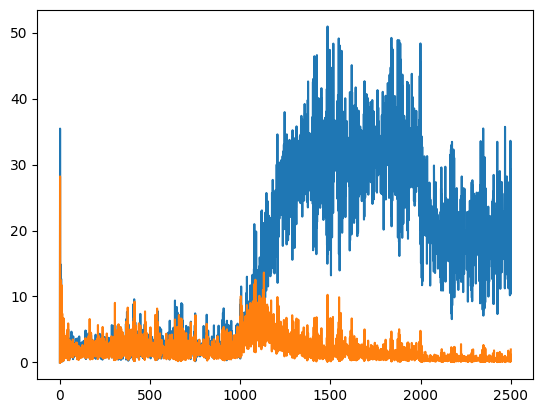

In [31]:

good_point = np.array([0.32,0.25,0.0,0.0])

tmpu = get_fixed_points(good_point[0],good_point[1],good_point[2],good_point[3],0,0,abc_good_prams)
tmps = get_fixed_points(good_point[0],good_point[1],good_point[2],good_point[3],40,0,abc_good_prams)

run = selective_inh_foureqn_prod(abc_good_prams,0,good_point[0],
                                           good_point[1],good_point[2],good_point[3],0.2,time)
#print(run['data'])
import matplotlib.pyplot as plt
plt.plot(run['data'][0])
plt.plot(run['data'][1])
#print(abc_good_prams['JnmdaE'][0,0])
trial_data = eval_single_trial(run,time)



In [32]:
print(abc_good_prams)

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Sep 13 17:53:56 2022', '__version__': '1.0', '__globals__': [], 'I0E': array([[0.77071143]]), 'I0I': array([[1.02669666]]), 'JgabaE': array([[-0.46992407]]), 'JgabaI': array([[-0.64211589]]), 'JnmdaE': array([[0.42345756]]), 'JnmdaI': array([[0.57431432]])}
